# Link to tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [1]:
%matplotlib inline
import argparse
import os
import random

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vision_utils

from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Make Notebook reproducable

In [2]:
random.seed(1337)
torch.manual_seed(1337)
torch.use_deterministic_algorithms(True)

# Define Training Hyperparameters

In [7]:
data_root: str = "./data/"
num_workers: int = 2
batch_size: int = 128
image_size: int = 64
num_channels: int = 3
len_z_vector: int = 100
depth_feature_map_discriminator: int = 64
depth_feature_map_generator: int = 64
num_epochs: int = 5
learning_rate: float = 0.0002
beta_1: float = 0.5
num_gpus: int = 1

# Data Loading

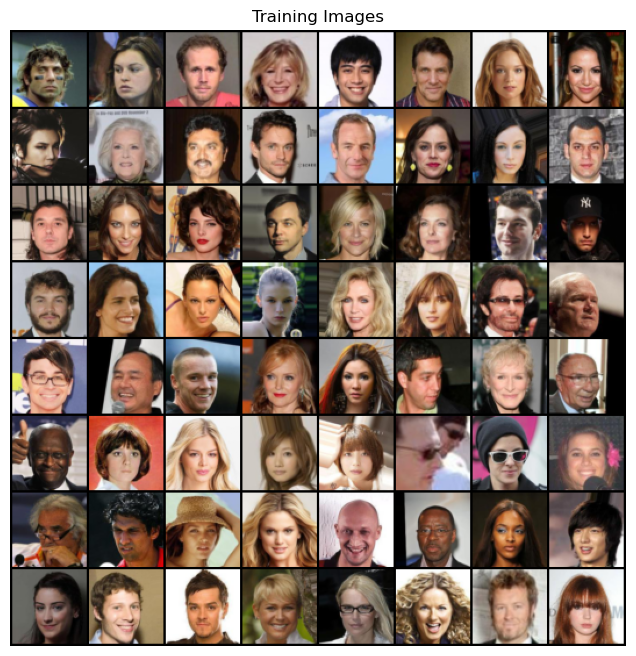

In [8]:
dataset: datasets.ImageFolder = datasets.ImageFolder(
    root=data_root,
    transform=transforms.Compose(
        [
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )
)

dataloader: DataLoader = DataLoader(dataset=dataset, 
                                    batch_size=batch_size,
                                    shuffle=True,
                                    num_workers=num_workers)

device = torch.device("cuda" if (torch.cuda.is_available() and num_gpus > 0) else "cpu")

real_batch_images = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vision_utils.make_grid(real_batch_images[0].to(device)[:64], padding=2, normalize=True).cpu(), (1,2,0)))

# Init Weights

In [12]:
def init_weights(model):
    classname = model.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# Build Generator

In [13]:
class Generator(nn.Module):
    def __init__(self, num_gpus):
        super(Generator, self).__init__()
        self.num_gpus = num_gpus
        self.model = nn.Sequential(
            # Input Vector Z to Conv
            nn.ConvTranspose2d(len_z_vector, depth_feature_map_generator * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(depth_feature_map_generator * 8),
            nn.ReLU(True),
            # Upsample
            nn.ConvTranspose2d(depth_feature_map_generator * 8, depth_feature_map_generator * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(depth_feature_map_generator * 4),
            nn.ReLU(True),
            # Upsample
            nn.ConvTranspose2d(depth_feature_map_generator * 4, depth_feature_map_generator * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(depth_feature_map_generator * 2),
            nn.ReLU(True),
            # Upsample
            nn.ConvTranspose2d(depth_feature_map_generator * 2, depth_feature_map_generator, 4, 2, 1, bias=False),
            nn.BatchNorm2d(depth_feature_map_generator),
            nn.ReLU(True),
            # Final Upsample
            nn.ConvTranspose2d(depth_feature_map_generator, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.model(x)
        

In [14]:
generator: Generator = Generator(num_gpus).to(device)

if device.type == "cuda" and num_gpus > 1:
    generator: Generator = nn.DataParallel(generator, list(range(num_gpus)))

generator.apply(init_weights)

print(generator)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

# Build Discriminator

In [16]:
class Discriminator(nn.Module):
    def __init__(self, num_gpus):
        super(Discriminator, self).__init__()
        self.num_gpus = num_gpus
        self.model = nn.Sequential(
            # Input
            nn.Conv2d(num_channels, depth_feature_map_discriminator, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Downsample
            nn.Conv2d(depth_feature_map_discriminator, depth_feature_map_discriminator * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(depth_feature_map_discriminator * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Downsample
            nn.Conv2d(depth_feature_map_discriminator * 2, depth_feature_map_discriminator * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(depth_feature_map_discriminator * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Downsample
            nn.Conv2d(depth_feature_map_discriminator * 4, depth_feature_map_discriminator * 8 , 4, 2, 1, bias=False),
            nn.BatchNorm2d(depth_feature_map_discriminator * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Downsample
            nn.Conv2d(depth_feature_map_discriminator * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

In [17]:
discriminator: Discriminator = Discriminator(num_gpus).to(device)

if device.type == "cude" and num_gpus > 1:
    discriminator: Discriminator = nn.DataParallel(discriminator, list(range(num_gpus)))
    
discriminator.apply(init_weights)

print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# Loss Function & Optimizer

In [19]:
loss_function = nn.BCELoss()

fixed_noise = torch.randn(64, len_z_vector, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta_1, 0.999))
optimizer_generator = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta_1, 0.999))